<a href="https://colab.research.google.com/github/gahanleeo/DCEG_GWAS_course/blob/main/session3/03_FineMapping%26Colocalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Overview**

In this exercise, first we will be using fine-mapping (SuSiE) to identify the potential set of "statistically" causal variants in a particular region. Then we will use colocalization to evaluate whether a GWAS signal and eQTL association are driven by the same causal variant. We will go over two examples of this.

The entire exercise will be based on variant level summary statistics extracted from GWAS and eQTL studies.



## **Setup**
Before we get started, make sure you have the statgen_workshop folder added to your drive. See the link and screenshot below if you need help with this step.

*Important: We want to mount the google drive* for the data neeed for this workshop. Please open this link with your Google drive and find the "statgen_workshop" folder under "Share with me". Then add a shortcut to the folder under "My Drive", as shown in the screenshot.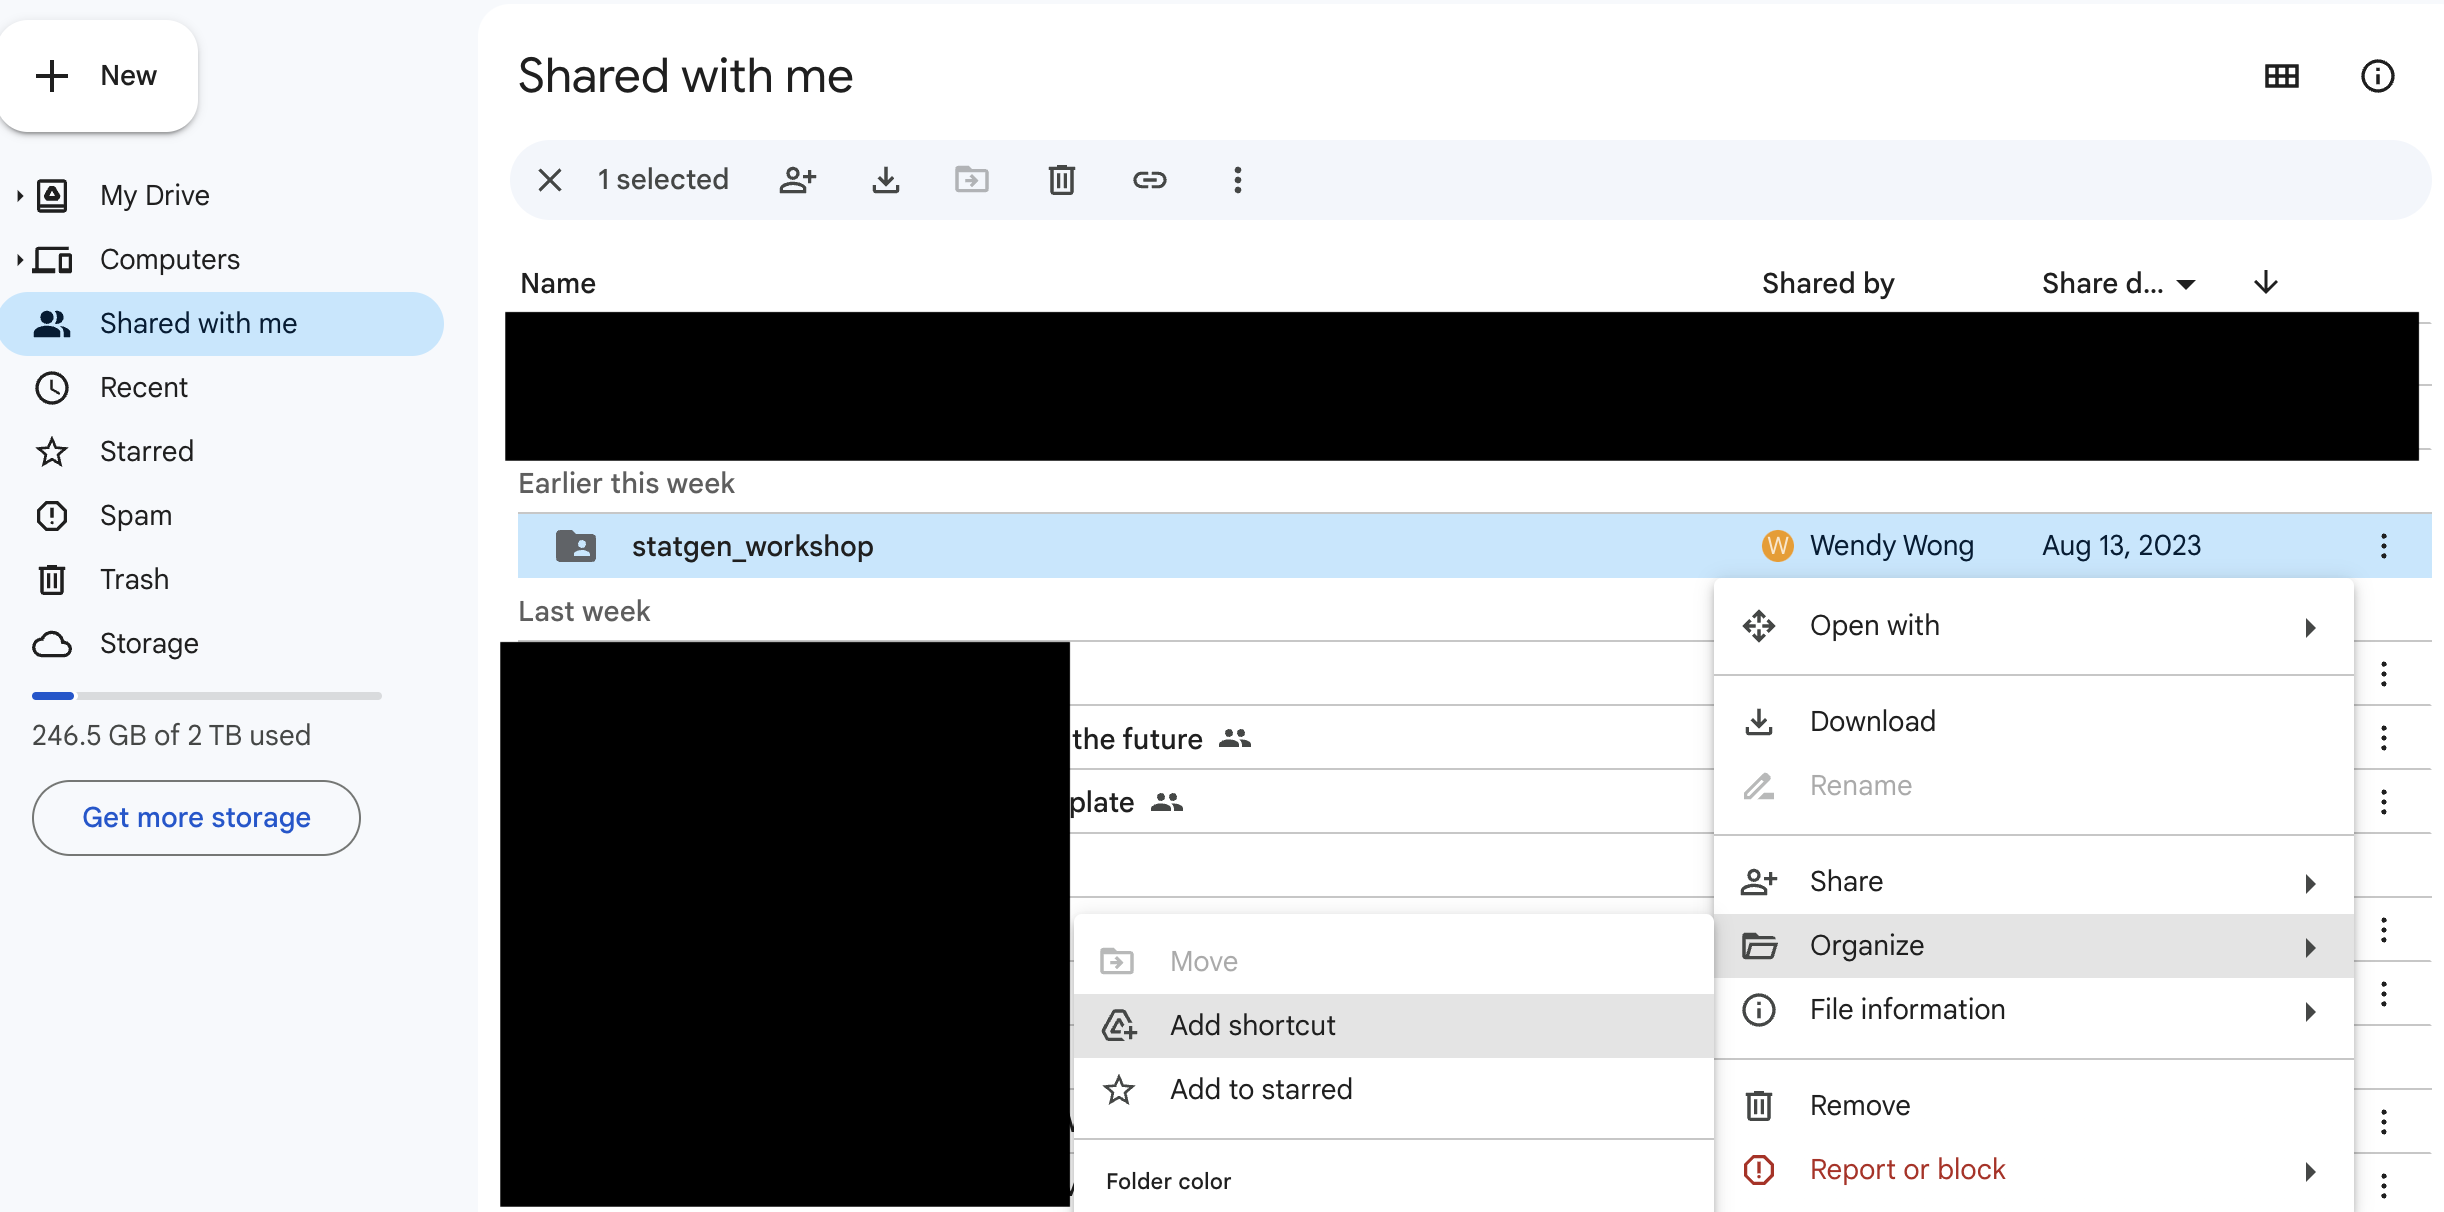


When you import the drive, your google will popup a security alert. Be sure to grant yourself access.

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


Now we can look at the contents of the drive using the list (ls) command and verify the drive is added to "MyDrive"

In [9]:
!ls /content/drive/MyDrive/statgen_workshop/data/workshop3/

!head /content/drive/MyDrive/statgen_workshop/data/workshop3/example_1_sumstat.txt

example_1_LD.ld.bin    example_2_LD.ld.bin    gene_expression_tissue1.txt
example_1_sumstat.txt  example_2_sumstat.txt  gene_expression_tissue2.txt
v CHR POS SNPID Allele1 Allele2 AC_Allele2 AF_Allele2 imputationInfo N BETA SE Tstat p.value p.value.NA Is.SPA.converge varT varTstar AF.Cases AF.Controls
10:122841079:G:A 10 122841079 rs11199756 G A 60223.4352941153 0.378525677524295 0.996135883716614 79550 -0.0436457245581105 0.0197003218509537 -112.462001052164 0.0267269424470142 0.026725063858371 1 2576.70143389257 2693.4364386148 0.368311865457645 0.379407922130955
10:122841377:G:C 10 122841377 rs79506723 G C 22475.9882352958 0.141269567789414 0.992547748548411 79550 -0.0636195298918118 0.0275816122367121 -83.6268226930942 0.0210775683452449 0.0210783925386718 1 1314.48350585592 1374.03492933286 0.13440161202821 0.141862805347472
10:122841529:A:G 10 122841529 rs12263945 A G 21916.8392156838 0.137755117634719 0.995012311748971 79550 -0.0495736439186116 0.0275667441011929 -65.23488384660

Load R magic, so that we can run R here and share variables

In [3]:
%load_ext rpy2.ipython

We will set path variables to simplify our coding to not require the full drive path for the input and output datasets as done before.

In [4]:
import os
input_dir="/content/drive/MyDrive/statgen_workshop/data/workshop3/"
analysis_dir=os.getcwd() + "/03_analysis/"
os.environ['input_dir']=input_dir
os.environ['analysis_dir']=analysis_dir

 Install required R libraries and set shared variables.

In [5]:
%%R -i input_dir -i analysis_dir

## Install packages

install.packages("susieR")
install.packages("coloc")

(as ‘lib’ is unspecified)












































	‘/tmp/RtmpVxyy9T/downloaded_packages’

(as ‘lib’ is unspecified)



















	‘/tmp/RtmpVxyy9T/downloaded_packages’



In [6]:
%%R
library(susieR); library(coloc); library(glue)

Lets take a look at the input files. Note: These will be different than session #1 and #2 as we are in a different folder for session #3. Be sure these files are listed so you confirm your directory and path variables are set correctly.

In [15]:
%%bash
mkdir -p ${analysis_dir}
ls ${input_dir}

head ${input_dir}/gene_expression_tissue1.txt

example_1_LD.ld.bin
example_1_sumstat.txt
example_2_LD.ld.bin
example_2_sumstat.txt
gene_expression_tissue1.txt
gene_expression_tissue2.txt
rsid chr pos effect_allele effect_allele_frequency p.value
rs11199756 10 122841079 A 0.378525677524295 0.0307967283570524
rs79506723 10 122841377 C 0.141269567789414 0.0225344001124164
rs12263945 10 122841529 G 0.137755117634719 0.0911232986842543
rs77929344 10 122841539 C 0.141160596985515 0.0271474274159231
rs117575294 10 122841575 C 0.0991439592807749 0.30188621440995
rs117842152 10 122841612 A 0.0991435649055506 0.274216705573906
rs79260765 10 122841658 G 0.0991008244907177 0.229044284786662
rs2252344 10 122842033 A 0.137505305579171 0.0620642519638576
rs141250929 10 122843301 A 0.0330850494816131 0.886003536435535


We will start off with Example 1 datasets. The files for example 1 are a GWAS summary statistics data for a region and corresponding LD matrix.

Read in and view the summary statistics of the region.

This is a local/regional manhattan plot for association in Biobank Japan for Breast Cancer and variants around the gene *FGFR2*.

In [11]:
%%R -i input_dir

## Read in the summary statistics file and print the top SNPs

ss = read.table(glue(input_dir,"example_1_sumstat.txt"),header = T)

print(head(ss[order(ss$p.value),]))

                    v CHR       POS      SNPID Allele1 Allele2 AC_Allele2
1584 10:123336494:C:T  10 123336494  rs2912781       C       T   76316.18
1575 10:123334457:G:A  10 123334457 rs10736303       G       A   76358.22
1574 10:123333997:C:T  10 123333997  rs7895676       C       T   76434.99
1593 10:123338654:G:A  10 123338654  rs2912778       G       A   77710.37
1588 10:123337335:A:G  10 123337335  rs2981579       A       G   90347.20
1586 10:123337117:C:T  10 123337117  rs2912780       C       T   90287.80
     AF_Allele2 imputationInfo     N       BETA         SE     Tstat
1584  0.4796743      0.9900358 79550 -0.1835128 0.01914894 -501.1285
1575  0.4799386      0.9844196 79550 -0.1826062 0.01920789 -495.5860
1574  0.4804211      0.9823624 79550 -0.1820788 0.01922687 -493.1725
1593  0.4884373      0.9944625 79550 -0.1786107 0.01908206 -491.1094
1588  0.5678642      0.9999338 79550 -0.1640659 0.01921172 -445.2199
1586  0.5674909      0.9990582 79550 -0.1641003 0.01921918 -444.9654

Now, lets read in and view the LD matrix.  

The usual command to get that is

plink --bfile GENOTYPE_FILE --keep-allele-order --extract SNP_LIST --r bin4

In PLINK outputs, generally the LD matrix is provided in .bin (binary) format.

However, we want the correlation matrix not the r2 matrix. This is generated by --r bin4 option.

In [12]:
%%R

## Read in the binary LD file with the number of SNPs
## LD matrix

n.snp = dim(ss)[1]
ld = readBin(glue(input_dir,"example_1_LD.ld.bin"), what="numeric", size=4, n=(n.snp)^2)
ld = matrix(ld,ncol = n.snp,byrow = T)
ld[is.na(ld)] = 0
print(round(ld[1:6,1:6],3))

      [,1]   [,2]   [,3]   [,4]   [,5]   [,6]
[1,] 1.000  0.579  0.537  0.581  0.248  0.248
[2,] 0.579  1.000 -0.222  0.997 -0.128 -0.128
[3,] 0.537 -0.222  1.000 -0.216 -0.136 -0.136
[4,] 0.581  0.997 -0.216  1.000 -0.128 -0.128
[5,] 0.248 -0.128 -0.136 -0.128  1.000  1.000
[6,] 0.248 -0.128 -0.136 -0.128  1.000  1.000


We will first take a look at the local/regional manhattan plot to get a sense of the associations in the region. We will color each of the SNPs by its LD (r2) with the index or sentinel variant (SNP with the lowest p-value).

It is always important to get a sense of the association patterns in the region before diving into the analysis.

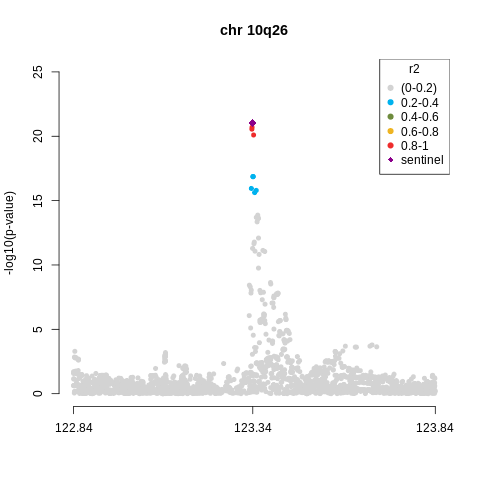

In [13]:
%%R

# Identify the index variant
indx <- which.min(ss$p.value)

# Get LD (r2) of the rest of the variants with the index variant and set the colors accordingly.
ldx <- abs(ld[,indx])^2
colsx = cut(ldx^2,breaks = c(0,0.2,0.4,0.6,0.8,1))
levels(colsx) = c("lightgrey","deepskyblue2","darkolivegreen4","goldenrod2","firebrick2")

# Plot the regional manhattan plot.
plot(ss$POS,-log10(ss$p.value),col = as.character(colsx),pch = 19,xaxt = "n",xlab = " ",ylab = "-log10(p-value)",ylim = c(0,25),
     cex = 0.8,main = "chr 10q26",bty = "n")

# Add the axis ticks
axis(1,at = c(min(ss$POS),ss$POS[indx],max(ss$POS)),labels = round(c(min(ss$POS),ss$POS[indx],max(ss$POS))/1000000,2))

# Highlight the sentinel variant
points(x = ss$POS[indx],y = -log10(ss$p.value)[indx],col = "darkmagenta",pch = 18,cex = 1.5)

# Add the legends
legend("topright",legend = c("(0-0.2)","0.2-0.4","0.4-0.6","0.6-0.8","0.8-1","sentinel"),col = c("lightgrey","deepskyblue2","darkolivegreen4","goldenrod2","firebrick2","darkmagenta"),
       pch = c(19,19,19,19,19,18),title = "r2")

Now lets run SuSiE

SuSiE requires beta (effect sizes), SE and LD. Alternatively you can use t-stat or Z-values (beta/SE) as well

In [16]:
%%R
# Z value allowed as well
s1 = susie_rss(bhat=ss$BETA,shat = ss$SE,R = ld,estimate_residual_variance= F,L = 10)

Lets look at the broad output SuSiE provides

In [17]:
%%R

summary(s1)
# output cs value
# how to interpert it?
# those 3 varialbe (snps) containts 95% of probabliy


Variables in credible sets:

 variable variable_prob cs
     1584     0.5270525  1
     1575     0.2488099  1
     1574     0.1792178  1

Credible sets summary:

 cs cs_log10bf cs_avg_r2 cs_min_r2       variable
  1   15.38138 0.9856642 0.9827065 1574,1575,1584


Lets look at all the outputs that a "SuSiE" object provides.

Most of them are used for internal computation.

The most relevant for us is the Posterior Inclusion Probability (pip)

In [18]:
%%R
str(s1)

List of 18
 $ alpha                 : num [1:10, 1:3232] 7.88e-20 3.66e-04 3.66e-04 3.66e-04 3.65e-04 ...
 $ mu                    : num [1:10, 1:3232] -1.867 -0.968 -0.966 -0.969 -0.975 ...
 $ mu2                   : num [1:10, 1:3232] 4.47 1.56 1.56 1.57 1.58 ...
 $ KL                    : num [1:10] 9.194 0.761 0.758 0.764 0.775 ...
 $ lbf                   : num [1:10] 35.4169 0.0836 0.0831 0.0839 0.0855 ...
 $ lbf_variable          : num [1:10, 1:3232] -0.489 0.251 0.251 0.251 0.251 ...
 $ sigma2                : num 1
 $ V                     : num [1:10] 89.22 1.69 1.68 1.7 1.72 ...
 $ pi                    : num [1:3232] 0.000309 0.000309 0.000309 0.000309 0.000309 ...
 $ null_index            : num 0
 $ XtXr                  : num [1:3232, 1] -0.709 -0.441 -0.282 -0.449 -0.291 ...
 $ converged             : logi TRUE
 $ elbo                  : num [1:6] 35 35.3 35.4 35.4 35.4 ...
 $ niter                 : int 6
 $ X_column_scale_factors: num [1:3232] 1 1 1 1 1 1 1 1 1 1 ...
 

Lets order the the variants by PIP and see if we can recover the credible set conceptually.

In [19]:
%%R

## Attach the pip to the summary statistics data frame
ss$pip = s1$pip

## Look at the SNPs with highest PIP
head(ss[order(ss$pip,decreasing = T),c(2,3,4,11,12,14,21)])

     CHR       POS       SNPID       BETA         SE      p.value        pip
1584  10 123336494   rs2912781 -0.1835128 0.01914894 9.386194e-22 0.52705254
1575  10 123334457  rs10736303 -0.1826062 0.01920789 1.965507e-21 0.24880990
1574  10 123333997   rs7895676 -0.1820788 0.01922687 2.797969e-21 0.17921784
1893  10 123432652  rs12356902  0.1163761 0.02952858 8.109688e-05 0.07005368
40    10 122854845 rs146141333  0.2104783 0.06834423 2.072241e-03 0.06749049
1593  10 123338654   rs2912778 -0.1786107 0.01908206 7.963266e-21 0.04945925


A summary plot for fine-mapping output should include both informations: PIP and credible set (CS). Here's an example.

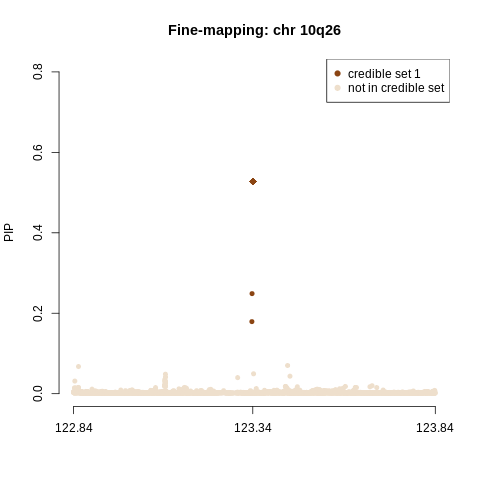

In [20]:
%%R
## Set the colors
cols.pip <- rep("antiquewhite2",dim(ss)[1])
cols.pip[s1$sets$cs$L1] <- "chocolate4"

plot(ss$POS,s1$pip,col = as.character(cols.pip),pch = 19,xaxt = "n",xlab = " ",ylab = "PIP",cex = 0.8,bty = "n",ylim = c(0,0.8), main = "Fine-mapping: chr 10q26")

## Add axis ticks
axis(1,at = c(min(ss$POS),ss$POS[indx],max(ss$POS)),labels = round(c(min(ss$POS),ss$POS[indx],max(ss$POS))/1000000,2))

# Highligh the sentinel variant
points(x = ss$POS[indx],y = s1$pip[indx],col = cols.pip[indx],pch = 18,cex = 1.5)

# Add the legend
legend("topright",legend = c("credible set 1","not in credible set"), col = c("chocolate4","antiquewhite2"),pch = 19)

Visualize the SNPs selected in credible set in context of the overall regional plot

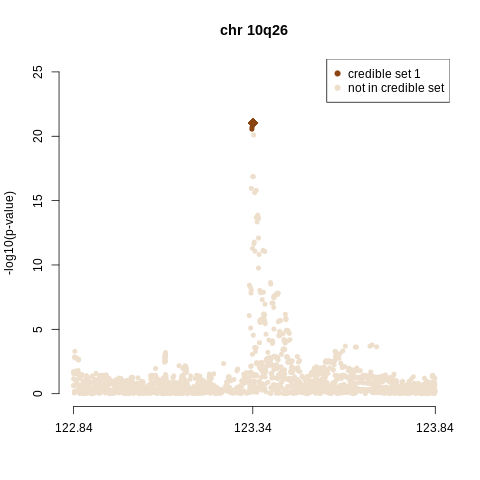

In [21]:
%%R

plot(ss$POS,-log10(ss$p.value),col = as.character(cols.pip),pch = 19,xaxt = "n",xlab = " ",ylab = "-log10(p-value)",ylim = c(0,25),cex = 0.8,main = "chr 10q26",bty = "n")
axis(1,at = c(min(ss$POS),ss$POS[indx],max(ss$POS)),labels = round(c(min(ss$POS),ss$POS[indx],max(ss$POS))/1000000,2))
points(x = ss$POS[indx],y = -log10(ss$p.value)[indx],col = cols.pip[indx],pch = 18,cex = 2)
legend("topright",legend = c("credible set 1","not in credible set"), col = c("chocolate4","antiquewhite2"),pch = 19)

Now we will perform colocalization analysis on this summary GWAS data for the 10q26 region with the gene expression summary statistics in two different tissues.

We will first read in the variant level summary statistics for eQTL in tissue1.

In [22]:
%%R
# tool coloc
library(coloc)

#Read in the gene expression summary statistics
# exrcted from GTEx p-value, MAF
ss.H4 = read.table(glue(input_dir,"gene_expression_tissue1.txt"),header = T)


head(ss.H4)

         rsid chr       pos effect_allele effect_allele_frequency    p.value
1  rs11199756  10 122841079             A              0.37852568 0.03079673
2  rs79506723  10 122841377             C              0.14126957 0.02253440
3  rs12263945  10 122841529             G              0.13775512 0.09112330
4  rs77929344  10 122841539             C              0.14116060 0.02714743
5 rs117575294  10 122841575             C              0.09914396 0.30188621
6 rs117842152  10 122841612             A              0.09914356 0.27421671


In [24]:
%%R -i input_dir

## Create coloc data frame objects with GWAS summary statistics and gene expression summary statistics.
## It consists of several components as listed below. Look at the vignette for full list of options.

dx1 = list()
dx1$beta <- ss$BETA
dx1$varbeta <- ss$SE^2
dx1$pvalues <- ss$p.value
dx1$snp <- ss$SNPID
dx1$N <- 80000
dx1$type <- "cc"
dx1$s <- 0.033
check_dataset(dx1)

# eqtl list
dx2 <- list()
dx2$pvalues <- ss.H4$p.value; dx2$N <- 670; dx2$MAF <- ifelse(ss.H4$effect_allele_frequency > 0.5,yes = 1- ss.H4$effect_allele_frequency,no = ss.H4$effect_allele_frequency)
dx2$type <- "quant";dx2$sdY <- 1; dx2$snp <- ss.H4$rsid
check_dataset(dx2)

NULL


Now lets see whether the GWAS summary statistics and eQTL summary statistics in tissue1 colocalize

In [25]:
%%R

## Main command for colocalization

coloc.abf(dx1,dx2)

# usually 95% above consider as coloc

PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 1.06e-30  1.15e-15  9.31e-18  9.02e-03  9.91e-01 
[1] "PP abf for shared variant: 99.1%"



SNP Priors



   p1    p2   p12 
1e-04 1e-04 1e-05 


Hypothesis Priors



        H0     H1     H2        H3      H4
 0.2168541 0.3232 0.3232 0.1044259 0.03232


Posterior



       nsnps           H0           H1           H2           H3           H4 
3.232000e+03 1.064880e-30 1.145083e-15 9.307991e-18 9.018048e-03 9.909820e-01 


Lets take a look at the regional manhattan plots to get a sense of colocalization.

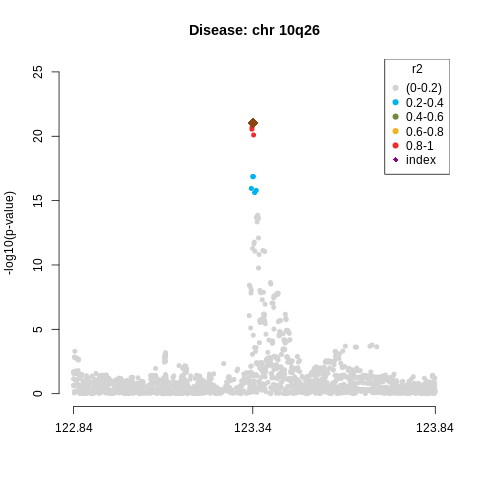

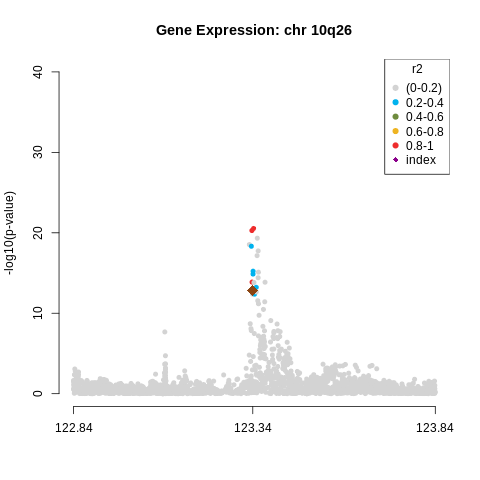

In [26]:
%%R -i input_dir

## Plot regional manhattan plot for disease GWAS

plot(ss$POS,-log10(ss$p.value),col = as.character(colsx),pch = 19,xaxt = "n",xlab = " ",ylab = "-log10(p-value)",ylim = c(0,25),cex = 0.8,main = "Disease: chr 10q26",bty = "n")
axis(1,at = c(min(ss$POS),ss$POS[indx],max(ss$POS)),labels = round(c(min(ss$POS),ss$POS[indx],max(ss$POS))/1000000,2))
points(x = ss$POS[indx],y = -log10(ss$p.value)[indx],col = cols.pip[indx],pch = 18,cex = 2)
legend("topright",legend = c("(0-0.2)","0.2-0.4","0.4-0.6","0.6-0.8","0.8-1","index"),col = c("lightgrey","deepskyblue2","darkolivegreen4","goldenrod2","firebrick2","darkmagenta"),
       pch = c(19,19,19,19,19,18),title = "r2")

## Plot regional manhattan plot for gene expression.

plot(ss.H4$pos,-log10(ss.H4$p.value),col = as.character(colsx),pch = 19,xaxt = "n",xlab = " ",ylab = "-log10(p-value)",ylim = c(0,40),cex = 0.8,main = "Gene Expression: chr 10q26",bty = "n")
axis(1,at = c(min(ss.H4$pos),ss.H4$pos[indx],max(ss.H4$pos)),labels = round(c(min(ss.H4$pos),ss.H4$pos[indx],max(ss.H4$pos))/1000000,2))
points(x = ss.H4$pos[indx],y = -log10(ss.H4$p.value)[indx],col = cols.pip[indx],pch = 18,cex = 2)
legend("topright",legend = c("(0-0.2)","0.2-0.4","0.4-0.6","0.6-0.8","0.8-1","index"),col = c("lightgrey","deepskyblue2","darkolivegreen4","goldenrod2","firebrick2","darkmagenta"),
       pch = c(19,19,19,19,19,18),title = "r2")



Lets try this with Tissue 2.

In [27]:
%%R

## Read in and view the eQTL summary statistics

ss.H4 = read.table(glue(input_dir,"gene_expression_tissue2.txt"),header = T)

print(head(ss.H4))



         rsid chr       pos effect_allele effect_allele_frequency     p.value
1  rs11199756  10 122841079             A              0.37852568 0.067725282
2  rs79506723  10 122841377             C              0.14126957 0.037640720
3  rs12263945  10 122841529             G              0.13775512 0.066175440
4  rs77929344  10 122841539             C              0.14116060 0.005451577
5 rs117575294  10 122841575             C              0.09914396 0.237873528
6 rs117842152  10 122841612             A              0.09914356 0.280576588


In [28]:
%%R -i input_dir

dx1 = list()
dx1$beta <- ss$BETA
dx1$varbeta <- ss$SE^2
dx1$pvalues <- ss$p.value
dx1$snp <- ss$SNPID
dx1$N <- 80000
dx1$type <- "cc"
dx1$s <- 0.033
check_dataset(dx1)

dx2 <- list()
dx2$pvalues <- ss.H4$p.value; dx2$N <- 300; dx2$MAF <- ifelse(ss.H4$effect_allele_frequency > 0.5,yes = 1- ss.H4$effect_allele_frequency,no = ss.H4$effect_allele_frequency)
dx2$type <- "quant";dx2$sdY <- 1; dx2$snp <- ss.H4$rsid

coloc.abf(dx1,dx2)



PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 7.99e-39  8.59e-24  8.91e-16  9.58e-01  4.19e-02 
[1] "PP abf for shared variant: 4.19%"



SNP Priors



   p1    p2   p12 
1e-04 1e-04 1e-05 


Hypothesis Priors



        H0     H1     H2        H3      H4
 0.2168541 0.3232 0.3232 0.1044259 0.03232


Posterior



       nsnps           H0           H1           H2           H3           H4 
3.232000e+03 7.990155e-39 8.591940e-24 8.910400e-16 9.581076e-01 4.189244e-02 


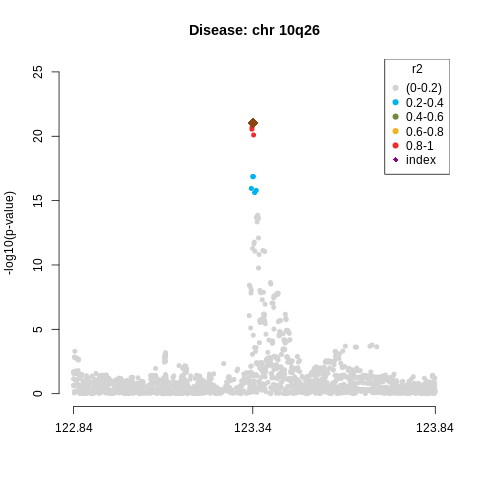

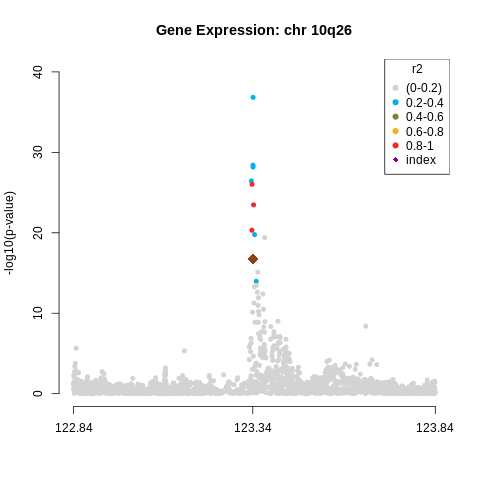

In [29]:
%%R -i input_dir

## Plot regional manhattan plot for disease GWAS

plot(ss$POS,-log10(ss$p.value),col = as.character(colsx),pch = 19,xaxt = "n",xlab = " ",ylab = "-log10(p-value)",ylim = c(0,25),cex = 0.8,main = "Disease: chr 10q26",bty = "n")
axis(1,at = c(min(ss$POS),ss$POS[indx],max(ss$POS)),labels = round(c(min(ss$POS),ss$POS[indx],max(ss$POS))/1000000,2))
points(x = ss$POS[indx],y = -log10(ss$p.value)[indx],col = cols.pip[indx],pch = 18,cex = 2)
legend("topright",legend = c("(0-0.2)","0.2-0.4","0.4-0.6","0.6-0.8","0.8-1","index"),col = c("lightgrey","deepskyblue2","darkolivegreen4","goldenrod2","firebrick2","darkmagenta"),
       pch = c(19,19,19,19,19,18),title = "r2")

## Plot regional manhattan plot for gene expression

plot(ss.H4$pos,-log10(ss.H4$p.value),col = as.character(colsx),pch = 19,xaxt = "n",xlab = " ",ylab = "-log10(p-value)",ylim = c(0,40),cex = 0.8,main = "Gene Expression: chr 10q26",bty = "n")
axis(1,at = c(min(ss.H4$pos),ss.H4$pos[indx],max(ss.H4$pos)),labels = round(c(min(ss.H4$pos),ss.H4$pos[indx],max(ss.H4$pos))/1000000,2))
points(x = ss.H4$pos[indx],y = -log10(ss.H4$p.value)[indx],col = cols.pip[indx],pch = 18,cex = 2)
legend("topright",legend = c("(0-0.2)","0.2-0.4","0.4-0.6","0.6-0.8","0.8-1","index"),col = c("lightgrey","deepskyblue2","darkolivegreen4","goldenrod2","firebrick2","darkmagenta"),
       pch = c(19,19,19,19,19,18),title = "r2")


# always plot the result to check to get the sense or not

Example 2.

Now that we are familiar with fine mapping using SuSiE and colocalization, lets take a look at a slightly more complicated example of fine mapping.

We have summary statistics for the 5p13.33 region nearby the *TERT* gene.

In [30]:
%%R -i input_dir

library(susieR)
library(glue)

## Read in and prepare summary statistics & LD matrix for fine mapping.
ss = read.table(glue(input_dir,"example_2_sumstat.txt"),header = T)
n.snp = dim(ss)[1]

print(head(ss[order(ss$p.value),]))

ld = readBin(glue(input_dir,"example_2_LD.ld.bin"), what="numeric", size=4, n=(n.snp)^2)
ld = matrix(ld,ncol = n.snp,byrow = T)
ld[is.na(ld)] = 0


     CHR     POS effect_allele other_allele       beta standard_error
1827   5 1280013             C            T  0.0836905      0.0110728
1819   5 1277462             A            G -0.0788171      0.0110719
1622   5 1221084             C            T  0.1576540      0.0246359
1824   5 1279849             C            G  0.0718037      0.0112733
1639   5 1223936             T            C  0.1540200      0.0246315
1644   5 1224375             T            G  0.1539540      0.0246291
     effect_allele_frequency     p.value       rsid    variant_id
1827                0.428298 4.08790e-14  rs7734992 5_1280013_T_C
1819                0.492439 1.08993e-12 rs33961405 5_1277462_G_A
1622                0.916710 1.56016e-10 rs12513763 5_1221084_T_C
1824                0.415944 1.89789e-10 rs10054203 5_1279849_G_C
1639                0.911341 4.02717e-10  rs7733011 5_1223936_C_T
1644                0.911366 4.08150e-10 rs11744165 5_1224375_G_T


Take a look at the regional manhattan plot.

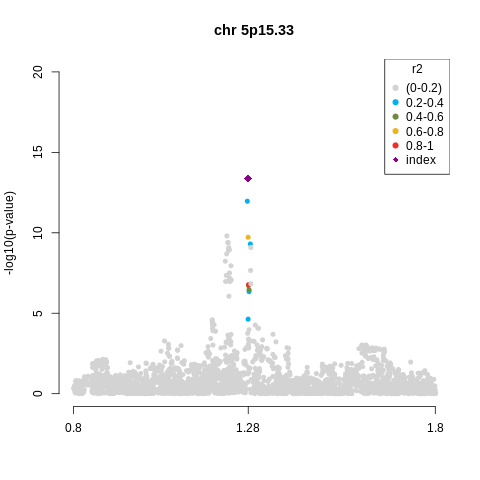

In [31]:
%%R -i input_dir

indx <- which.min(ss$p.value)
ldx <- abs(ld[,indx])^2
colsx = cut(ldx^2,breaks = c(0,0.2,0.4,0.6,0.8,1))
levels(colsx) = c("lightgrey","deepskyblue2","darkolivegreen4","goldenrod2","firebrick2")
table(colsx)
plot(ss$POS,-log10(ss$p.value),col = as.character(colsx),pch = 19,xaxt = "n",xlab = " ",ylab = "-log10(p-value)",ylim = c(0,20),cex = 0.8,main = "chr 5p15.33",bty = "n")
axis(1,at = c(min(ss$POS),ss$POS[indx],max(ss$POS)),labels = round(c(min(ss$POS),ss$POS[indx],max(ss$POS))/1000000,2))
points(x = ss$POS[indx],y = -log10(ss$p.value)[indx],col = "darkmagenta",pch = 18,cex = 1.5)
legend("topright",legend = c("(0-0.2)","0.2-0.4","0.4-0.6","0.6-0.8","0.8-1","index"),col = c("lightgrey","deepskyblue2","darkolivegreen4","goldenrod2","firebrick2","darkmagenta"),
       pch = c(19,19,19,19,19,18),title = "r2")



Now, lets run fine mapping (SuSiE) in this region.

In [32]:
%%R -i input_dir

## Run SuSiE

s1 = susie_rss(bhat=ss$beta,shat = ss$standard_error,R = ld,estimate_residual_variance= F,L = 10)
summary(s1)


Variables in credible sets:

 variable variable_prob cs
     1827    0.54211227  1
     1819    0.45694921  1
     1622    0.28497597  2
     1639    0.12858093  2
     1644    0.12687771  2
     1664    0.07268501  2
     1669    0.06100206  2
     1657    0.05639003  2
     1663    0.05615177  2
     1661    0.05615143  2
     1673    0.05524894  2
     1654    0.05448495  2
     1620    0.03503048  2

Credible sets summary:

 cs cs_log10bf cs_avg_r2 cs_min_r2
  2   3.119943 0.9956450 0.9869717
  1   5.761127 0.5003821 0.5003821
                                               variable
 1620,1622,1639,1644,1654,1657,1661,1663,1664,1669,1673
                                              1819,1827


Susie gives two crediable set,
one with bunch snps 1620,1622,1639,1644,1654,1657,1661,1663,1664,1669,1673 in cs1 ; the other with 1819,1827 in cs2


Lets plot the credible sets and PIP into a summary plot

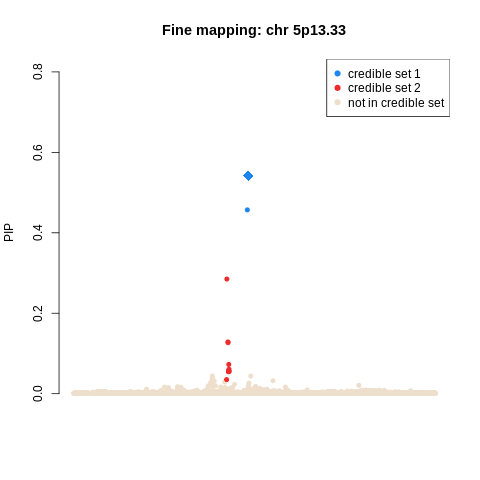

In [33]:
%%R -i input_dir

## Set up the coloring scheme

cols.pip <- rep("antiquewhite2",dim(ss)[1])
cols.pip[s1$sets$cs$L1] <- "dodgerblue2"
cols.pip[s1$sets$cs$L2] <- "firebrick2"

## Summary fine mapping plot with variants in different credible sets colored.

plot(ss$POS,s1$pip,col = as.character(cols.pip),pch = 19,xaxt = "n",xlab = " ",ylab = "PIP",cex = 0.8,bty = "n",ylim = c(0,0.8), main = "Fine mapping: chr 5p13.33")
points(x = ss$POS[indx],y = s1$pip[indx],col = cols.pip[indx],pch = 18,cex = 2)
legend("topright",legend = c("credible set 1", "credible set 2","not in credible set"), col = c("dodgerblue2","firebrick2","antiquewhite2"),pch = 19)


Lets take a look at the variants within the credible sets

In [34]:
%%R

## LD between the variants in credible set 1
print(round(ld[s1$sets$cs$L1,s1$sets$cs$L1],2))



      [,1]  [,2]
[1,]  1.00 -0.71
[2,] -0.71  1.00


In [35]:
%%R -i input_dir

## LD between the variants in credible sets 1 and 2, tehy are indepentant as it is low LD.
## the value is r squard
print(round(ld[s1$sets$cs$L1,s1$sets$cs$L2],3))

       [,1]   [,2]   [,3]   [,4]   [,5]   [,6]   [,7]   [,8]   [,9]  [,10]
[1,] -0.049 -0.051 -0.051 -0.051 -0.050 -0.050 -0.050 -0.050 -0.050 -0.050
[2,]  0.123  0.124  0.124  0.124  0.123  0.123  0.123  0.123  0.123  0.123
      [,11]
[1,] -0.051
[2,]  0.124


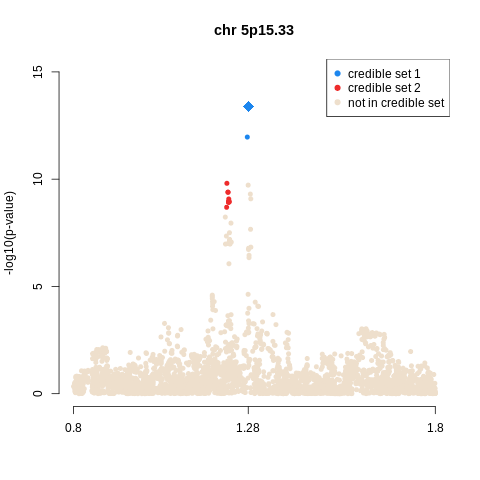

In [36]:
%%R -i input_dir

## Variants in the credible sets in the regional manhattan plot.

plot(ss$POS,-log10(ss$p.value),col = as.character(cols.pip),pch = 19,xaxt = "n",xlab = " ",ylab = "-log10(p-value)",ylim = c(0,15),cex = 0.8,main = "chr 5p15.33",bty = "n")
axis(1,at = c(min(ss$POS),ss$POS[indx],max(ss$POS)),labels = round(c(min(ss$POS),ss$POS[indx],max(ss$POS))/1000000,2))
points(x = ss$POS[indx],y = -log10(ss$p.value)[indx],col = cols.pip[indx],pch = 18,cex = 2)
legend("topright",legend = c("credible set 1", "credible set 2","not in credible set"), col = c("dodgerblue2","firebrick2","antiquewhite2"),pch = 19)


Challenge: How would you perform colocalization on this dataset?

Note: the assumption of coloc is a single causal variant.

Hint: Look at [this page](https://cran.r-project.org/web/packages/coloc/vignettes/a06_SuSiE.html)

Idea: Use SuSiE to partition the locus into separate distinctive signals. Use coloc on each of the distinct signals.